In [1]:
from IPython.core.display import HTML 

# Introduction to MongoDB with PyMongo and NOAA Data

This notebook provides a basic walkthrough of how to use MongoDB and is based on a tutorial originally by [Alberto Negron](http://altons.github.io/python/2013/01/21/gentle-introduction-to-mongodb-using-pymongo/).

## What is MongoDB?
MongoDB is a cross-platform document-oriented NoSQL database. Rather than the traditional table-based relational database structure, MongoDB stores JSON-like documents with dynamic schemas (called BSON), making data integration easier and faster for certain types of applications.

## Features
Some of the features include:    

__Document-orientation__
Instead of taking a business subject and breaking it up into multiple relational structures, MongoDB can store the business subject in the minimal number of documents.    

__Ad hoc queries__
MongoDB supports field, range queries, regular expression searches. Queries can return specific fields of documents and also include user-defined JavaScript functions.    

__Indexing__
Any field in a MongoDB document can be indexed – including within arrays and embedded documents. Primary and secondary indices are available.    

__Aggregation__
Aggregation operators can be strung together to form a pipeline – analogous to Unix pipes.    


## When it makes sense to use MongoDB    
Metadata records are frequently stored as JSON, and almost anything you get from an API will be JSON. For example, check out the [metadata records](https://data.noaa.gov/data.json) for the National Oceanic and Atmospheric Administration. 

MongoDB is a great tool to use with JSON data because it stores structured data as JSON-like documents, using dynamic rather than predefined schemas. 

In MongoDB, an element of data is called a document, and documents are stored in collections. One collection may have any number of documents. Collections are a bit like tables in a relational database, and documents are like records. But there is one big difference: every record in a table has the same fields (with, usually, differing values) in the same order, while each document in a collection can have completely different fields from the other documents.

Documents are Python dictionaries that can have strings as keys and can contain various primitive types (int, float,unicode, datetime) as well as other documents (Python dicts) and arrays (Python lists).

## Getting started
First we need to import `json` and `pymongo`.

Note that the `pprint` module provides a capability to “pretty-print” arbitrary Python data structures in a form which can be used as input to the interpreter. This is particularly helpful with JSON. You can read more about `pprint` [here](https://docs.python.org/2/library/pprint.html).

In [2]:
import json
import pymongo
from pprint import pprint

## Connect    
Just as with the relational database example with `sqlite`, we need to begin by setting up a connection. With MongoDB, we will be using `pymongo`, though MongoDB also comes with a [console API that uses Javascript](https://docs.mongodb.org/manual/tutorial/write-scripts-for-the-mongo-shell/).    

Make sure you have launched Mongo on your system before you connect.

OS X - mongod

Windows - "C:\Program Files\MongoDB\Server\3.2\bin\mongod.exe"

To make our connection, we will use the PyMongo method `MongoClient`:

In [3]:
conn=pymongo.MongoClient()

## Create and access a database    

Mongodb creates databases and collections automatically for you if they don't exist already. A single instance of MongoDB can support multiple independent databases. When working with PyMongo, we access databases using attribute style access, just like we did with `sqlite`:

In [4]:
db = conn.mydb

If your connection fails, verify your Mongo server is running.

In [5]:
conn.database_names()

[u'admin', u'local']

## Collections    
A collection is a group of documents stored in MongoDB, and can be thought of as roughly the equivalent of a table in a relational database. Getting a collection in PyMongo works the same as getting a database:

In [6]:
collection = db.my_collection

In [10]:
db.collection_names()

[u'my_collection']

## Insert data   
To insert some data into MongoDB, all we need to do is create a dict and call `insert_one` on the collection object:

In [8]:
doc = {"class":"xbus-502","date":"03-05-2016","instructor":"bengfort","classroom":"C222","roster_count":"25"}
collection.insert_one(doc)

You can put _anything_ in:

In [9]:
doc = {"class":"xbus-502","date":"03-05-2016","teaching_assistant":"bilbro", "sauce": "awesome"}
collection.insert_one(doc)

## A practical example

Rebecca Bilbro, former teaching assistant and current Visual Analytics instructor, has created this practical example for us to work through. 

At my job I have been working on a project to [help make Commerce datasets easier to find](https://github.com/CommerceDataService/recordtagger). One of the barriers to searching for records is when the keywords return either too many or too few results. It can also be a problem if the keywords are too technical for lay users. 

One solution is to use topic modeling to extract latent themes from the metadata records and then probabilistically assign each record a more sensical set of keywords based on its proximity (via kmeans) to the topics.

In order to get started, first I had to gather up a bunch of JSON metadata records and store them for analysis and modeling. Here's what I did: 

```python
import requests

NOAA_URL = "https://data.noaa.gov/data.json"

def load_data(URL):
    """
    Loads the data from URL and returns data in JSON format.
    """
    r = requests.get(URL)
    data = r.json()
    return data
    
noaa = load_data(NOAA_URL)
```

But...this kinda takes a long time, so I've created a file for you that contains a small chunk of the records to use for today's workshop.

In [11]:
with open("data_sample.json") as data_file:    
    noaa = json.load(data_file)

In [12]:
len(noaa)

1722

### Checking out the data
Now let's print out just one record to examine the structure. 

In [20]:
pprint(noaa[0].keys())

[u'publisher',
 u'identifier',
 u'description',
 u'keyword',
 u'title',
 u'distribution',
 u'temporal',
 u'modified',
 u'language',
 u'bureauCode',
 u'accrualPeriodicity',
 u'spatial',
 u'programCode',
 u'contactPoint',
 u'accessLevel',
 u'@type']


Or say we wanted just the "description" field:

In [14]:
pprint(noaa[0]['description'])

u"This data set contains sea ice and snow measurements collected during aircraft landings associated with the Soviet Union's historical Sever airborne and North Pole drifting station programs. The High-Latitude Airborne Annual Expeditions Sever (Sever means North) took place in 1937, 1941, 1948-1952, and 1954-1993 (Konstantinov and Grachev, 2000). In Spring 1993, the last (45th) Sever expedition finished long-term activity in the Arctic. Snow and sea ice data were collected, along with meteorological and hydrological measurements (the latter are not part of this data set). Up to 202 landings were accomplished each year.  The data set contains measurements of 23 parameters, including ice thickness and snow depth on the runway and surrounding area; ridge, hummock, and sastrugi dimensions and areal coverage; and snow density. The sea ice thickness data are of particular importance, as ice thickness measurements for the Arctic Basin are scarce. These data are a subset of those used to crea

### Define the database
We will want to enter these records into our database. But first, we'll define a specific database for the NOAA records:

In [15]:
db = conn.earthwindfire

In [17]:
conn.database_names()

[u'admin', u'local', u'mydb']

### Define the collection
Next we define the collection where we'll insert the NOAA metadata records:

In [18]:
records = db.records

### Insert data    
Then we loop through each record in the NOAA dataset and insert just the target information for each into the collection.

In [21]:
# What data fields seem important to you? Add them below following the examples:

def insert(metadata):
    for dataset in metadata:
        data ={}
        data["title"] = dataset["title"]
        data["description"] = dataset["description"]
        data["keywords"] = dataset["keyword"]
        data["accessLevel"] = dataset["accessLevel"]
        data["lang"] = dataset["language"]
        data["modified"] = dataset["modified"]
        data["bureauCode"] = dataset["bureauCode"]
        # choose your own
        # choose your own
        # choose your own 
        # choose your own

        records.insert_one(data)

insert(noaa)

In [22]:
# Check to make sure they're all in there
records.count()

3444

### Querying 

#### Querying with `.findOne( )`    
The find_one() method selects and returns a single document from a collection and returns that document (or None if there are no matches). It is useful when you know there is only one matching document, or are only interested in the first match

In [23]:
records.find_one()

{u'_id': ObjectId('58d6b4080bdb8206da1ff621'),
 u'accessLevel': u'public',
 u'description': u"This data set contains sea ice and snow measurements collected during aircraft landings associated with the Soviet Union's historical Sever airborne and North Pole drifting station programs. The High-Latitude Airborne Annual Expeditions Sever (Sever means North) took place in 1937, 1941, 1948-1952, and 1954-1993 (Konstantinov and Grachev, 2000). In Spring 1993, the last (45th) Sever expedition finished long-term activity in the Arctic. Snow and sea ice data were collected, along with meteorological and hydrological measurements (the latter are not part of this data set). Up to 202 landings were accomplished each year.  The data set contains measurements of 23 parameters, including ice thickness and snow depth on the runway and surrounding area; ridge, hummock, and sastrugi dimensions and areal coverage; and snow density. The sea ice thickness data are of particular importance, as ice thickness

#### Querying with `.find( )`
To get more than a single document as the result of a query we use the `find()` method. `find()` returns a Cursor instance, which allows us to iterate over all matching documents.

```python
records.find()
```

For example, we can iterate over the first 2 documents (there are a lot in the collection and this is just an example) in the records collection

In [24]:
for rec in records.find()[:2]:
    pprint(rec)

{u'_id': ObjectId('58d6b4080bdb8206da1ff621'),
 u'accessLevel': u'public',
 u'description': u"This data set contains sea ice and snow measurements collected during aircraft landings associated with the Soviet Union's historical Sever airborne and North Pole drifting station programs. The High-Latitude Airborne Annual Expeditions Sever (Sever means North) took place in 1937, 1941, 1948-1952, and 1954-1993 (Konstantinov and Grachev, 2000). In Spring 1993, the last (45th) Sever expedition finished long-term activity in the Arctic. Snow and sea ice data were collected, along with meteorological and hydrological measurements (the latter are not part of this data set). Up to 202 landings were accomplished each year.  The data set contains measurements of 23 parameters, including ice thickness and snow depth on the runway and surrounding area; ridge, hummock, and sastrugi dimensions and areal coverage; and snow density. The sea ice thickness data are of particular importance, as ice thickness

#### Searching 
MongoDB queries are represented as JSON-like structures just like documents. To build a query, you just need to specify a dictionary with the properties you want the results to match. For example, let's say we were just interested in publically available satellite data from [NESDIS](http://www.nesdis.noaa.gov/).

This query will match all documents in the records collection with keywords code "NESDIS".

In [25]:
records.find({"keywords": "NESDIS"}).count()

2234

1117 is probably more than we want to print out in a Jupyter Notebook...    

We can further narrow our search by adding additional fields

In [26]:
records.find({"keywords": "NESDIS","keywords": "Russia","accessLevel":"public"}).count()

4

Since there's only two, let's check them out:

In [27]:
for r in records.find({"keywords": "NESDIS","keywords": "Russia","accessLevel":"public"}):
    pprint(r)

{u'_id': ObjectId('58d6b40a0bdb8206da1ff622'),
 u'accessLevel': u'public',
 u'description': u'This data set was distributed by NSIDC until October, 2003, when it was withdrawn from distribution because it duplicates the NOAA National Climatic Data Center (NCDC) data set DSI-3720. The NCDC data set is revised and updated beyond what was distributed by NSIDC. This archive consists of monthly precipitation measurements from 622 stations located in the Former Soviet Union.',
 u'keywords': [u'Continent > Europe > Eastern Europe > Russia',
               u'EARTH SCIENCE > Atmosphere > Precipitation > Precipitation Amount',
               u'EARTH SCIENCE > Atmosphere > Precipitation > Precipitation Rate',
               u'EARTH SCIENCE > Atmosphere > Precipitation > Rain',
               u'EARTH SCIENCE > Atmosphere > Precipitation > Snow',
               u'EARTH SCIENCE > Terrestrial Hydrosphere > Snow/Ice > Snow Cover',
               u'EOSDIS > Earth Observing System Data Information Syste

### If you already know SQL...

The following table provides an overview of common SQL aggregation terms, functions, and concepts and the corresponding MongoDB aggregation operators:    
    
| SQL Terms, Functions, and Concepts  | MongoDB Aggregation Operators  |
| ----------------------------------  |:-------------------------------|
| WHERE                               | \$match                        |
| GROUP BY                            | \$group                        |
| HAVING                              | \$match                        |
| SELECT	                          | \$project                      |
| ORDER BY	                          | \$sort                         |
| LIMIT                               | \$limit                        |
| SUM()   	                          | \$sum                          |
| COUNT()	                          | \$sum                          |
| join	                              | \$lookup                       |

But...thanks to MongoDB's nested data structures, we can also do a lot of things we can't do in a relational database. 

### Length    
Let's look for some entries that have way too many keywords:

In [28]:
cursor = db.records.find({"$where": "this.keywords.length > 100"}).limit(2);
for rec in cursor:
    pprint(rec)

{u'_id': ObjectId('58d6b40a0bdb8206da1ff662'),
 u'accessLevel': u'public',
 u'description': u'The data contain raw and processed values concerning wave size and direction, energy spectral data (both original and processed), and, where available, sea surface temperature, air temperature and pressure, wind speed and direction. The data are collected in real-time and transmitted to CDIP at SIO, La Jolla, CA, where it is processed and submitted to quality control procedures.',
 u'keywords': [u'DOC/NOAA/NESDIS/NODC > National Oceanographic Data Center',
               u'NESDIS',
               u'NOAA',
               u'U.S. Department of Commerce',
               u'DOC/NOAA/NESDIS/NCEI > National Centers for Environmental Information',
               u'NESDIS',
               u'NOAA',
               u'U.S. Department of Commerce',
               u'oceanography',
               u'Datawell Mark 3 directional buoy',
               u'Digital Paros pressure sensor',
               u'RM Young ane

### Full text search with a text index
One of the things that makes MongoDB special is that it enables us to create search indexes. Indexes provide high performance read operations for frequently used queries.

In particular, a __text index__ will enable us to search for string content in a collection. _Keep in mind that a collection can have at most one text index._ 

We will create a text index on the description field so that we can search inside our NOAA records text:

In [29]:
db.records.create_index([('description', 'text')])

u'description_text'

To test our newly created text index on the description field, we will search documents using the `$text` operator. Let's start by looking for all the documents that have the word 'precipitation' in their description field. 

In [30]:
cursor = db.records.find({'$text': {'$search': 'precipitation'}})
for rec in cursor:
    print(rec)

{u'lang': [u'en-US'], u'_id': ObjectId('58d6b40a0bdb8206da1ff645'), u'description': u"Integrated Surface Data (ISD) is digital data set DSI-3505, archived at the National Climatic Data Center (NCDC). The ISD database is composed of worldwide surface weather observations from over 20,000 stations, collected and stored from sources such as the Automated Weather Network (AWN), the Global Telecommunications System (GTS), the Automated Surface Observing System (ASOS), and data keyed from paper forms. Most digital observations are decoded either at operational centers and forwarded to the Federal Climate Complex (FCC) in Asheville, NC, or decoded at the FCC. The US Air Force Combat Climatology Center (AFCCC), the National Climatic Data Center (NCDC), and the US Navy's Fleet Numerical Meteorological and Oceanographical Command Detachment (FNMOD), make up the FCC in Asheville. Each agency is responsible for data ingest, quality control, and customer support for surface climatological data. All

In [31]:
cursor = db.records.find({'$text': {'$search': 'fire'}})
cursor.count()

22

If we want to create a new text index, we can do so by first dropping the first text index:

In [32]:
db.records.drop_index("description_text") 

We can also create a __wildcard__ text index for scenarios where we want any text fields in the records to be searchable. In such scenarios you can index all the string fields of your document using the $** wildcard specifier.

The query would go something like this:

In [33]:
db.records.create_index([("$**","text")])

u'$**_text'

In [34]:
cursor = db.records.find({'$text': {'$search': "Russia"}})
for rec in cursor:
    pprint(rec)

{u'_id': ObjectId('58d6b4620bdb8206da1fff5a'),
 u'accessLevel': u'public',
 u'bureauCode': [u'006:48'],
 u'description': u"The Midwater Assessment and Conservation Engineering (MACE) program of the Alaska Fisheries Science Center (AFSC; NOAA National Marine Fisheries Service) conducted an acoustic-trawl (AT) stock assessment survey in the eastern Bering Sea during the summer of 2010 to estimate the distribution and abundance of walleye pollock (Gadus chalcogrammus). The survey was conducted between 5 June and 7 August, 2010, along the eastern Bering Sea (EBS) shelf and in the Cape Navarin area of Russia. The survey was divided into three segments; leg 1 was 5 June to 24 June, leg 2 was 29 June to 16 July, and leg 3 was 20 July to 7 August, 2010. The survey was conducted onboard NOAA Ship Oscar Dyson, a 64 meter stern trawler equipped with acoustic and oceanographic instrumentation in addition to trawling and biological sampling capabilities. The primary instrumentation for the survey w

### Projections 

Projections allow you to pass along the documents with only the specified fields to the next stage in the pipeline. The specified fields can be existing fields from the input documents or newly computed fields.

For example, let's redo our fulltext Russia search, but project just the titles of the records:

In [35]:
cursor = db.records.find({'$text': {'$search': "Russia"}}, {"title": 1,"_id":0 })
for rec in cursor:
    print(rec)

{u'title': u'Eastern Bering Sea Acoustic-Trawl Survey of Walleye Pollock (DY1006)'}
{u'title': u'Temperature, salinity, and other data from buoy casts in the Arctic Ocean, Barents Sea and Beaufort Sea from 1948 to 1993 (NCEI Accession 9800040)'}
{u'title': u'International Geophysical Year, 1957-1958: Drifting Station Alpha Documentary Film'}
{u'title': u'Morphometric Characteristics of Ice and Snow in the Arctic Basin: Aircraft Landing Observations from the Former Soviet Union, 1928-1989'}
{u'title': u'International Geophysical Year, 1957-1958: Drifting Station Alpha Documentary Film'}
{u'title': u'Morphometric Characteristics of Ice and Snow in the Arctic Basin: Aircraft Landing Observations from the Former Soviet Union, 1928-1989'}
{u'title': u'Monthly Mean Precipitation Sums at Russian Arctic Stations, 1966-1990'}
{u'title': u'Temperature, salinity, and other data from buoy casts in the Arctic Ocean, Barents Sea and Beaufort Sea from 1948 to 1993 (NCEI Accession 9800040)'}
{u'title'

### Limit    

`.limit()` passes the first _n_ documents unmodified to the pipeline where _n_ is the specified limit. For each input document, this method outputs either one document (for the first _n_ documents) or zero documents (after the first _n_ documents).

In [36]:
cursor = db.records.find({'$text': {'$search': "Russia"}}, {"title": 1,"_id":0 }).limit(2)
for rec in cursor:
    print(rec)

{u'title': u'Eastern Bering Sea Acoustic-Trawl Survey of Walleye Pollock (DY1006)'}
{u'title': u'Temperature, salinity, and other data from buoy casts in the Arctic Ocean, Barents Sea and Beaufort Sea from 1948 to 1993 (NCEI Accession 9800040)'}


### Aggregate
MongoDB can perform aggregation operations with `.aggregate()`, such as grouping by a specified key and evaluating a total or a count for each distinct group.    

Use the `$group` stage to group by a specified key using the \_id field. `$group` accesses fields by the field path, which is the field name prefixed by a dollar sign.    

For example, we can use `$group` to aggregate all the languages of the NOAA records:

In [37]:
cursor = db.records.aggregate(
    [
        {"$group": {"_id": "$lang", "count": {"$sum": 1}}}
    ]
)
for document in cursor:
    pprint(document)

{u'_id': [u'en-US'], u'count': 3444}


Or we can combine `$match` and `$group` to aggregate the titles of just the public access records that match the word 'Soviet':

In [38]:
cursor = db.records.aggregate(
    [
        {"$match": {'$text': {'$search': "Soviet"}, "accessLevel": "public"}},
        {"$group": {"_id": "$title"}}
    ]
)

for document in cursor:
    pprint(document)

{u'_id': u'Historical temperature, salinity, oxygen, pH, and meteorological data collected from Former Soviet Union platforms Lomonosov, Murmanets, and Akademik Shokalsky in 1933 - 1962 years from Arctic Ocean, Barents Sea, Bering Sea, Chukchi Sea, East Siberian Sea, Kara Sea, and Laptev Sea (NCEI Accession 0108117)'}
{u'_id': u'Morphometric Characteristics of Ice and Snow in the Arctic Basin: Aircraft Landing Observations from the Former Soviet Union, 1928-1989'}
{u'_id': u'Former Soviet Union Monthly Precipitation Archive, 1891-1993'}
{u'_id': u'AFSC/NMML: North Pacific Right Whale Distribution, Abundance, and Habitat Use in the Southeastern Bering Sea, 2007 - 2011'}
{u'_id': u'Temperature, salinity, dissolved oxygen, phosphate, nitrite, pH, alkalinity, bottom depth, and meteorology data collected from Arctic Seas and North Western Pacific by various Soviet Union institutions from 1925-11-16 to 1989-05-18 (NODC Accession 0075099)'}
{u'_id': u'Arctic Ocean Drift Tracks from Ships, Buo

### The aggregation pipeline 

The [aggregation pipeline](https://docs.mongodb.org/manual/core/aggregation-pipeline/) allows MongoDB to provide native aggregation capabilities that corresponds to many common data aggregation operations in SQL.  Here's where you will put the pieces together to aggregate to get results that you can begin to analyze and perform machine learning on.

Here's an example of an aggregation pipeline:

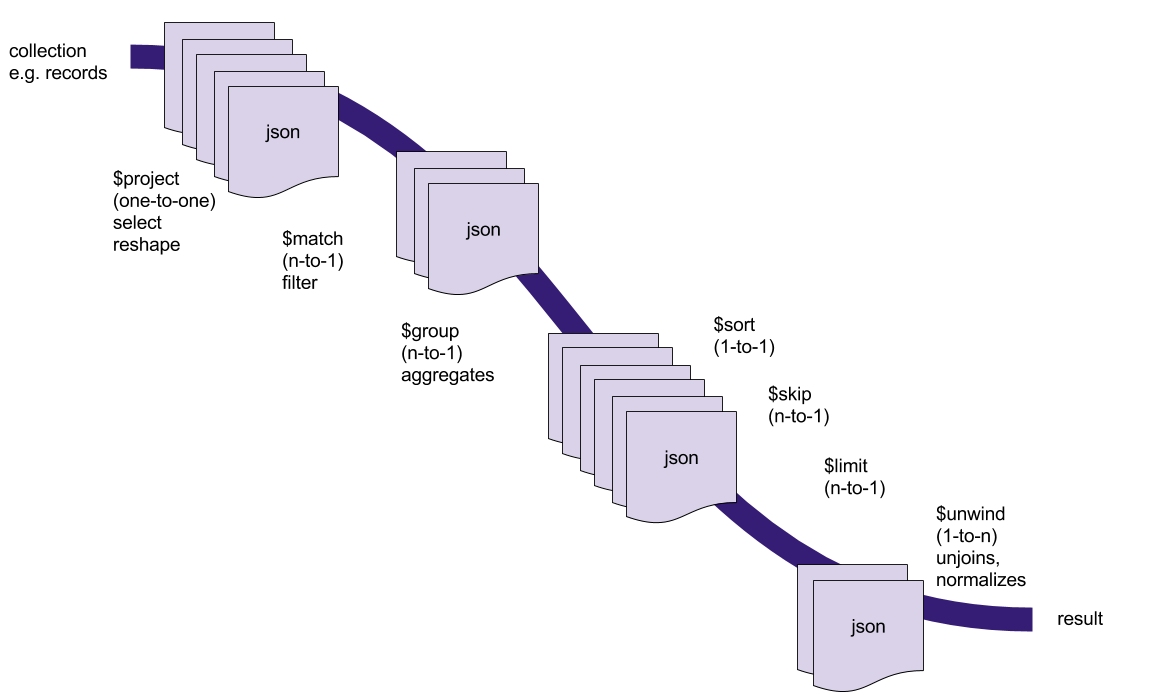

In [39]:
from IPython.display import Image
Image(filename='images/mongodb_pipeline.png', width=600, height=300)

### Removing data    

It's easy (almost too easy) to delete projects, collections, and databases in MongoDB. Before we get rid of anything, let's determine what collections we have in our database:

In [40]:
conn.earthwindfire.collection_names()

[u'records']

Now let's delete our records collection and check again to see what collections are in our database:

In [41]:
conn.earthwindfire.drop_collection("records")
conn.earthwindfire.collection_names()

[]

We can also just drop a database. First let's determine what databases we have:

In [46]:
conn.database_names()

[u'admin', u'local']

Now let's remove the earthwindfire database:

In [45]:
conn.drop_database("mydb")
conn.database_names()

Nice work!

## Miscellaneous

### Statistics    

The [`dbstats`](https://docs.mongodb.org/manual/reference/method/db.stats/) method returns statistics that reflect the use state of a single database:

In [47]:
db = conn.mydb
collection = db.my_collection
db.command({'dbstats': 1})

{u'avgObjSize': 0,
 u'collections': 0,
 u'dataSize': 0,
 u'db': u'mydb',
 u'fileSize': 0,
 u'indexSize': 0,
 u'indexes': 0,
 u'numExtents': 0,
 u'objects': 0,
 u'ok': 1.0,
 u'storageSize': 0,
 u'views': 0}

[`collStats`](https://docs.mongodb.org/manual/reference/command/collStats/) returns a variety of storage statistics for a given collection. Let's try it out for our NOAA records collection:

In [49]:
db.command({'collstats': 'my_collection', 'verbose': 'true' })